# Time Series Analysis

Data with a time component needs different methods to understand its behaviour and/or predict future values. Having time as a variable and use it for forecasting, we are assuming the future depends on the past. Usually, it's possible to get good predictions only for a short time horizon.


In [1]:
# Add local modules
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


## Time components

A time series, can be decomposed in four components:
- **Level**: constant value that best represent the time series
- **Trend**: the slope indicating if values are increasing or decreasing
- **Seasonality**: repeating patterns over time
- **Noise**: variability that can't be explained using the previous components

To visualize these components, let's create a mocked time series.

In [2]:
import numpy as np
import pandas as pd

from datetime import date

N = 1000
start_date = date(2017, 7, 1)
level = 5
trend_weight = 0.005
period_weight = 0.2
lags= {7: 0.05, 2: 0.01, 1: 0.03}
additional_features = {'A': 0.2, 'B': -0.3}
noise = 0.001

# Create series
time = np.arange(N)
time_series = level + trend_weight*time + period_weight*np.sin(2*np.pi*time/180) + noise*np.random.randn(N) 

# Add other features and time dependencies
data_ts = pd.DataFrame(time_series, columns=['y'])
for f, w in additional_features.items():
    data_ts[f] = np.random.randn(N)
    data_ts['y'] =  data_ts['y'] + w*data_ts[f] 
for l, w in lags.items():
    lags_series = w*data_ts['y'].shift(l, fill_value=level)
data_ts['y'] = data_ts['y'] + lags_series

data_ts.index = pd.date_range(start= start_date, periods=N, freq='D')

In [3]:
data_ts.head()

,y,A,B
2017-07-01,5.181162,-0.702336,-0.572618
2017-07-02,5.131503,0.291156,0.300306
2017-07-03,4.805973,-0.003029,1.222831
2017-07-04,5.682753,0.724866,-1.209463
2017-07-05,4.802745,-1.750945,0.198091


## Data preparation

Test set should have always values after the training set to avoid information leaked in the training set.

In [4]:
split_point = int(N*0.8)
training, test = data_ts.iloc[0:split_point, :], data_ts.iloc[split_point:, :]

## Defining a baseline

We can set the value from the previous day or the previous weekday as a baseline to know if our model is better than a simple rule. In our example, we will set the value from the previous day as baseline.

In [5]:
from sklearn.metrics import mean_squared_error

test['pred_bl'] = test['y'].shift(1)
test.loc[test.index[0], 'pred_bl'] = training.loc[training.index[-1], 'y']
rmse_bl = mean_squared_error(test['y'], test['pred_bl'], squared=False)
print(f'RMSE for baseline is {rmse_bl}')

RMSE for baseline is 0.5169111795380807


## Data Analysis

To analyze the data, we will use only the training data set.

For many statistical procedures, it's assumed that time series are stationary, which means its values don't depend on time and therefore, it's independent. 

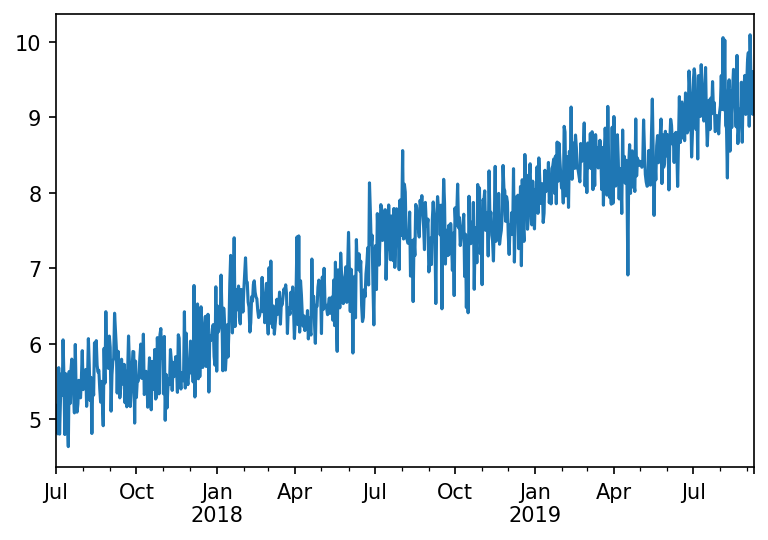

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

training['y'].plot()

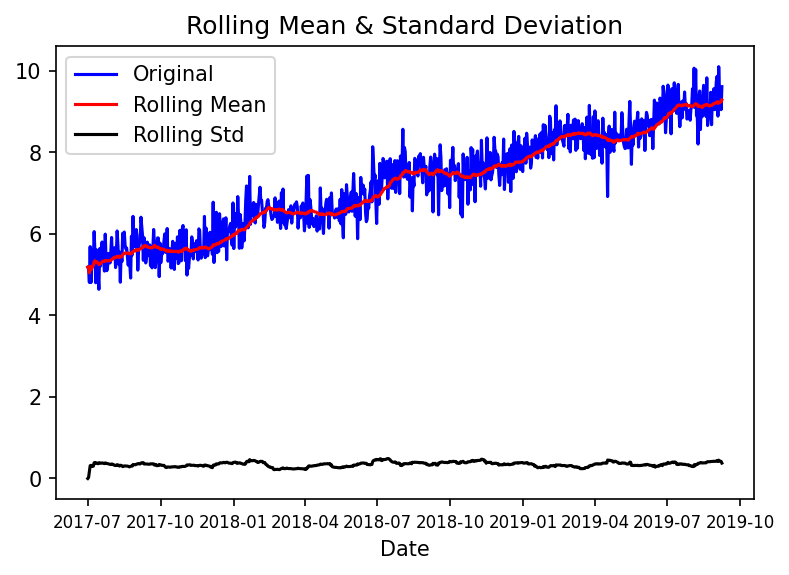

Results of Dickey-Fuller Test:
Test Statistic                  -0.213561
p-value                          0.936886
#Lags Used                      13.000000
Number of Observations Used    786.000000
Critical Value (1%)             -3.438697
Critical Value (5%)             -2.865224
Critical Value (10%)            -2.568732
dtype: float64


In [7]:
from src.data_analysis import test_stationarity

test_stationarity(training['y'])

As the time series is not stationary, we have to transform it. We can do it calculating the difference between the value and the lag estimated by the Dicker-Fuller test or summing the trend and residuals in the seasonal decomposition. For this examples, we will do it using differences.

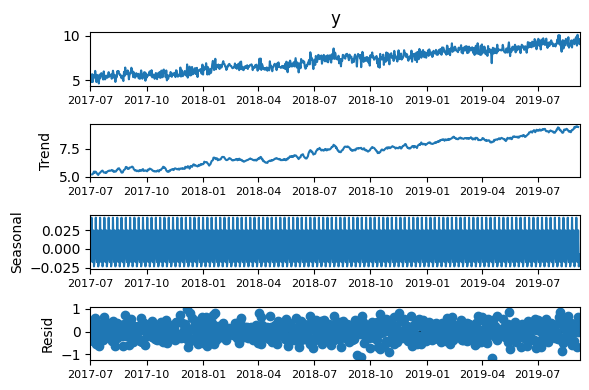

In [8]:
from src.data_analysis import make_stationary

training, dftest, decompose  = make_stationary(training, 'y', 'diff')

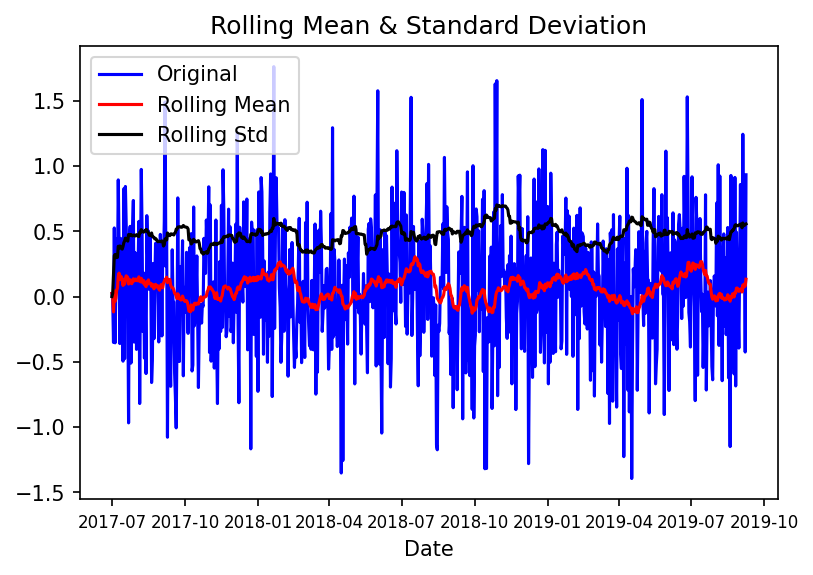

Results of Dickey-Fuller Test:
Test Statistic                  -4.678382
p-value                          0.000092
#Lags Used                      21.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


In [9]:
test_stationarity(training['y_stationary'])

After the transformation, the time series is stationary as the test shows above. To see the correlations with previous steps, we can plot the Autocorrelation Function (ACF) and the Partial Autorcorrelation Function (PAF). These are useful for AutoRegressive Integrated Moving Average (ARIMA) models to find an optimal order (p, d, q) where:
- **Lag order p:** lagged observation that has an effect on the current value
- **Degree of differencing d:** lagged observation to make the series stationary
- **Moving Average q:** time window to calculate the residual error that impacts the current observation

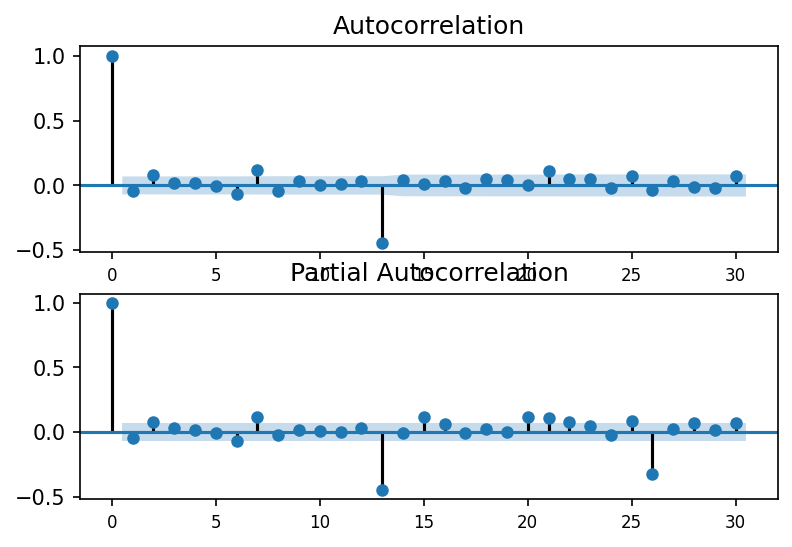

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(training['y_stationary'], ax=plt.gca())
plt.subplot(212)
plot_pacf(training['y_stationary'], ax=plt.gca())
plt.show()

In the example, the plots show the lag 18 should be considered to estimate the series that could be taken as a the **p** parameter in ARIMA or as a feature using any regression machine learning model.

After performing Time Series Analyis, we can continue with the standard machine learning workflow.

## Best practices for modeling

- Dataset should be split considering the timestamp and not random split
- Calculation a baseline with a lagged value before using any complex mdoels
- With time series is always recommended to make the values stationary

# References

- BROWNLEE, Jason. Introduction to time series forecasting with python: how to prepare data and develop models to predict the future. Machine Learning Mastery, 2017.